## Martin Dionne

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
#from sklearn.metrics import classification_report

# 1. Binary Classification

### 1.1 Titanic, but correctly this time

Take your linear regression model from the workshop 3.3 on the titanic dataset.

Swap OLS for logistic regresssion and compare the classification model metrics (accuracy, ROC plot, F1, precision/recall).

How much better is logistic regression than OLS on binary data?

In [3]:
df = sns.load_dataset('titanic')
# remove redundant features and deck (too much missing data)
df = df.drop(columns=['class', 'embark_town', 'alive', 'deck'])

# remove parch and embarked (p value > 0.05)
#df = df.drop(columns=['parch', 'embarked'])

#df.age = df.age.fillna(df.age.mean())
df.sex = df.sex.replace('male', 1).replace('female', 0)
df.alone = df.alone.replace(True, 1).replace(False, 0)
df.adult_male = df.adult_male.replace(True, 1).replace(False, 0)
df.who = df.who.replace(('child', 'woman', 'man'), (0,1,2))
#df.embarked = df.embarked.replace(('C', 'S', 'Q'), (0,1,2))
df = df.join(pd.get_dummies(df['embarked'], drop_first=True, prefix='embarked')).drop(columns=['embarked'])

#df['age_2'] = df.age ** 2
#df['age_3'] = df.age ** 3
df['fare'] = np.log(df.fare + 1)
df = df.dropna()
df


,survived,pclass,sex,age,sibsp,parch,fare,who,adult_male,alone,embarked_Q,embarked_S
0,0,3,1,22.0,1,0,2.110213,2,1,0,0,1
1,1,1,0,38.0,1,0,4.280593,1,0,0,0,0
2,1,3,0,26.0,0,0,2.188856,1,0,1,0,1
3,1,1,0,35.0,1,0,3.990834,1,0,0,0,1
4,0,3,1,35.0,0,0,2.202765,2,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
885,0,3,0,39.0,0,5,3.405355,1,0,0,1,0
886,0,2,1,27.0,0,0,2.639057,2,1,1,0,1
887,1,1,0,19.0,0,0,3.433987,1,0,1,0,1
889,1,1,1,26.0,0,0,3.433987,2,1,1,0,0


In [4]:
y = df.survived
X = df.drop(columns='survived')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [5]:
print('Linear Regression Model:')
lin_reg = LinearRegression().fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)
# convert results to binary predictions
f = lambda x: 1 if x > 0.5 else 0
vect_f = np.vectorize(f)
print(metrics.classification_report(y_test, vect_f(y_pred_lin)))

Linear Regression Model:
              precision    recall  f1-score   support

           0       0.81      0.86      0.84       125
           1       0.79      0.72      0.76        90

    accuracy                           0.80       215
   macro avg       0.80      0.79      0.80       215
weighted avg       0.80      0.80      0.80       215



In [6]:
print('Logistic Regression Model:')
log_reg = LogisticRegression().fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
print(metrics.classification_report(y_test, y_pred_log))

Logistic Regression Model:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       125
           1       0.80      0.73      0.76        90

    accuracy                           0.81       215
   macro avg       0.81      0.80      0.80       215
weighted avg       0.81      0.81      0.81       215



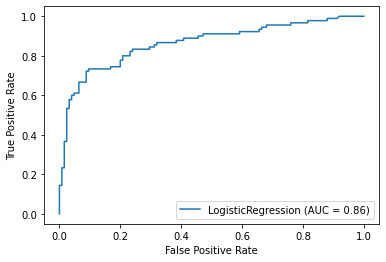

In [7]:
metrics.plot_roc_curve(log_reg, X_test, y_test);

In [8]:
# if prediction from the linear regression are converted to binary ouput (considering the model like a probability of survival) 
# the performance of the models are quite similar (accuracy of 0.80 vs 0.81 and f1 values are the same) 

# 2. Intro To Computer Vision

The [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) is a classic in computer vision. It's a database of manually written digits (from 0 to 9) scanned into a 28x28 pixel image.

The `X` matrix is 784 numbers (28x28) with numbers saying how dark the pixel is. The `y` variable is the number. The task is to use the images to do optical recognition.

You can fetch the dataset with the following command:

```
from sklearn.datasets import fetch_openml
fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
```

Use sklearn's logistic regression and any of the tricks you want to boost predictive accuracy. Here's a few notes:

- Use the sklearn `train_test_split` we saw in class to keep some holdout data to test on.

- You can use whatever sklearn preprocessing you think is relevant. Here's a few: 
```
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
```

- Since there's many features (especially if you use data augmentation like polynomial features), this is a good time to use regularization. Try to find the best regularization parameters possible.

- You should be able to get at least 80% on a test set size of 10_000

In [9]:
#https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=True)

In [10]:
X = mnist['data']
y = mnist['target']
test_sample = 10000
train_samples = len(y) - test_sample
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_samples, test_size=test_sample)

In [11]:
# scaling will not do much here since all data is within the same range
logreg = LogisticRegression(max_iter=500, solver='saga', tol=0.1).fit(X_train, y_train)
y_pred = logreg.predict(X_test)
#metrics.plot_confusion_matrix(logreg, X_test, y_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       982
           1       0.96      0.98      0.97      1170
           2       0.92      0.90      0.91      1034
           3       0.90      0.92      0.91      1044
           4       0.93      0.93      0.93       980
           5       0.89      0.84      0.87       848
           6       0.94      0.97      0.95       968
           7       0.95      0.92      0.93      1054
           8       0.89      0.89      0.89       939
           9       0.89      0.91      0.90       981

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [12]:
# I've read that the KNN model works well on this dataset
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
y_pred_knc = knc.predict(X_test)
#metrics.plot_confusion_matrix(knc, X_test, y_test)
print(metrics.classification_report(y_test, y_pred_knc))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       982
           1       0.98      1.00      0.99      1170
           2       0.98      0.97      0.98      1034
           3       0.97      0.97      0.97      1044
           4       0.98      0.97      0.97       980
           5       0.97      0.97      0.97       848
           6       0.98      0.99      0.99       968
           7       0.96      0.98      0.97      1054
           8       0.99      0.95      0.97       939
           9       0.96      0.96      0.96       981

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



# 3. Counting Poissons

The `data/fish.csv` is a data set of camping trips taken by 250 groups of people.

- The campers may or may not have done some fishing during their trip.
- If a group did some fishing, they would have caught zero or mor fish.
- We want to estimate not only how many fish were caught (if there was fishing done by a camping group), but also the probability that the camping group caught any fish at all.

Here's info on the columns:

**FISH_COUNT:** The number of fish that were caught. This will be our dependent variable y.

**LIVE_BAIT:** A binary variable indicating whether live bait was used.

**CAMPER:** Whether the fishing group used a camper van.

**PERSONS:** Total number of people in the fishing group. Note that in some groups, none of them may have fished.

**CHILDREN:** The number of children in the camping group.

Your task is to predict the number of fish caught (FISH_COUNT) by a camping group based on the values of LIVE_BAIT, CAMPER, PERSONS and CHILDREN variables.

Use what we learned on count variables and zero-inflated datasets to achieve the best model you can.

Interpret the models you used to give an analysis of each feature's effect on the predicted fish caught.

**N.B.** Please appreciate the effort I went through to find a fish dataset for a count problem pun.

In [13]:
df = pd.read_csv('data/fish.csv')
df.describe()
#df.groupby('FISH_COUNT').count().head(10)

,LIVE_BAIT,CAMPER,PERSONS,CHILDREN,FISH_COUNT
count,250.000000,250.000000,250.00000,250.000000,250.000000
mean,0.864000,0.588000,2.52800,0.684000,3.296000
std,0.343476,0.493182,1.11273,0.850315,11.635028
min,0.000000,0.000000,1.00000,0.000000,0.000000
25%,1.000000,0.000000,2.00000,0.000000,0.000000
50%,1.000000,1.000000,2.00000,0.000000,0.000000
75%,1.000000,1.000000,4.00000,1.000000,2.000000
max,1.000000,1.000000,4.00000,3.000000,149.000000


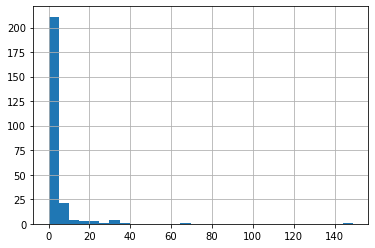

In [14]:
df.FISH_COUNT.hist(bins=30);

In [15]:
y = df['FISH_COUNT']
X = sm.add_constant(df.drop(columns=['FISH_COUNT']))
poisson = sm.Poisson(y, X).fit()
poisson.summary()

Optimization terminated successfully.
         Current function value: 3.167911
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:             FISH_COUNT   No. Observations:                  250
Model:                        Poisson   Df Residuals:                      245
Method:                           MLE   Df Model:                            4
Date:                Tue, 09 Feb 2021   Pseudo R-squ.:                  0.5193
Time:                        23:56:43   Log-Likelihood:                -791.98
converged:                       True   LL-Null:                       -1647.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.3901      0.265    -12.797      0.000      -3.909      -2.871
LIVE_BAIT      1.6697      0.233      7.160      0.000       1.213       2.127
CAMPER         0.8001      0.089      8.943      0.000       0.625       0.975
PERSONS        1.0740      0.039     27.534      0.000       0.998       1.150
CHILDREN      -1.7099      0.081    -21.005      0.000      -1.869      -1.550
==============================================================================
"""

In [16]:
zip = sm.ZeroInflatedPoisson(y, X).fit()
zip.summary()
# all features are statistically significant (p-value < 0.05)
# LIVE_BAIT is correlated positively with the number the FISH_COUNT
# so are CAMPER and PERSON in a lesser measure
# the number of CHILDREN actually reduce the FISH_COUNT (obviously)

Optimization terminated successfully.
         Current function value: 2.943385
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 22
C:\Users\user\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:              FISH_COUNT   No. Observations:                  250
Model:             ZeroInflatedPoisson   Df Residuals:                      245
Method:                            MLE   Df Model:                            4
Date:                 Tue, 09 Feb 2021   Pseudo R-squ.:                  0.3471
Time:                         23:56:43   Log-Likelihood:                -735.85
converged:                        True   LL-Null:                       -1127.0
Covariance Type:             nonrobust   LLR p-value:                5.101e-168
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const    -0.4805      0.177     -2.720      0.007      -0.827      -0.134
const            -2.5327      0.278     -9.099      0.000      -3.078      -1.987
LIVE_BAIT         1.7086      0.242      7.073      0.000       1.235       2.182
CAMPER            0.6745      0.094      7.191      0.000       0.491       0.858
PERSONS           0.8752      0.043     20.447      0.000       0.791       0.959
CHILDREN         -1.3957      0.090    -15.582      0.000      -1.571      -1.220
=================================================================================
"""

# 5. Survival Question

The `data/telco_churn.csv` dataset comes from [here](https://www.kaggle.com/blastchar/telco-customer-churn) and here is the description:

**Context**

"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]
Content

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents


**5.1 StreamingTV churn**

The `Tenure` column is how long the customer lasted. Make the survival curve for both the group using StreamingTV and the one not using it in the dataset

![](streamingtv.png)


**5.2 Survival Regression**

Use either lifelines or statsmodels to implement a survival regression model predicting tenure. Don't forget to use the churn column as the event column.

In [17]:
df = pd.read_csv('data/telco_churn.csv', na_values=' ')

# binary features
yes_no = ['Partner', 'Dependents', 'PhoneService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn' ]
df[yes_no] = df[yes_no].replace(('No internet service', 'No', 'Yes'), (np.nan,0,1))
df['gender'] = df['gender'].replace(('Female', 'Male'), (0,1))

# ordinal features
#df['MultipleLines'] = pd.Categorical(df['MultipleLines'], ordered=True, categories=['No phone service', 'No', 'Yes']).codes
df['MultipleLines'] = df['MultipleLines'].replace(('No phone service', 'No', 'Yes'), (0,1,2))
df['InternetService'] = df['InternetService'].replace(('No', 'DSL', 'Fiber optic'), (0,1,2))
df['Contract'] = df['Contract'].replace(('Month-to-month', 'One year', 'Two year'), (0,1,2))
df['PaymentMethod'] = df['PaymentMethod'].replace(('Mailed check', 'Electronic check', 'Bank transfer (automatic)', 'Credit card (automatic)'), (0,1,2,3))

# drop columns with unique rows
df = df.drop(columns=['customerID'])

#df['TotalCharges'] = df['TotalCharges'].fillna(df['MonthlyCharges'])
#df[yes_no] = df[yes_no].fillna(0)
df = df.dropna()
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0,1,1,29.85,29.85,0
1,1,0,0,0,34,1,1,1,1.0,0.0,1.0,0.0,0.0,0.0,1,0,0,56.95,1889.50,0
2,1,0,0,0,2,1,1,1,1.0,1.0,0.0,0.0,0.0,0.0,0,1,0,53.85,108.15,1
3,1,0,0,0,45,0,0,1,1.0,0.0,1.0,1.0,0.0,0.0,1,0,2,42.30,1840.75,0
4,0,0,0,0,2,1,1,2,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,2,1,1.0,0.0,1.0,1.0,1.0,1.0,1,1,0,84.80,1990.50,0
7039,0,0,1,1,72,1,2,2,0.0,1.0,1.0,0.0,1.0,1.0,1,1,3,103.20,7362.90,0
7040,0,0,1,1,11,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0,1,1,29.60,346.45,0
7041,1,1,1,0,4,1,2,2,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,74.40,306.60,1


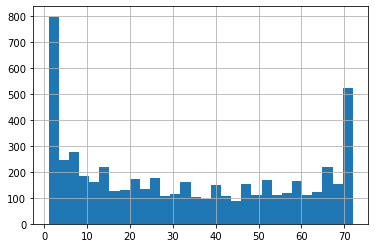

In [18]:
df.tenure.hist(bins=30);

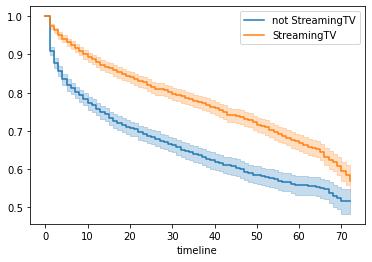

In [19]:
# 5.1 StreamingTV churn

from lifelines import KaplanMeierFitter

sub = df[['tenure', 'Churn', 'StreamingTV']]

kmf = KaplanMeierFitter()
kmf.fit(sub.tenure, sub.Churn)
#kmf.plot_survival_function()

groups = df['StreamingTV']
ix = (groups == 1)
kmf.fit(sub.tenure[~ix], sub.Churn[~ix], label='not StreamingTV')
ax = kmf.plot_survival_function()
kmf.fit(sub.tenure[ix], df.Churn[ix], label='StreamingTV')
ax = kmf.plot_survival_function(ax=ax)

In [20]:
# 5.2 Survival Regression  - Statsmodels
y = df['tenure']
X = df.drop(columns=['tenure', 'Churn'])
censor = df['Churn']

est = sm.PHReg(y, X, status=censor).fit()
est.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: PHReg
=======================================================================
Model:                        PH Reg          Sample size:         5512
Dependent variable:           tenure          Num. events:         1756
Ties:                         Breslow                                  
-----------------------------------------------------------------------
                  log HR log HR SE   HR      t     P>|t|  [0.025 0.975]
-----------------------------------------------------------------------
gender           -0.0553    0.0482 0.9462  -1.1475 0.2512 0.8609 1.0399
SeniorCitizen     0.0348    0.0572 1.0354   0.6088 0.5426 0.9256 1.1583
Partner          -0.1197    0.0563 0.8872  -2.1255 0.0335 0.7945 0.9907
Dependents       -0.0609    0.0722 0.9409  -0.8434 0.3990 0.8168 1.0839
PhoneService      1.0404    0.3746 2.8302   2.7774 0.0055 1.3582 5.8975
MultipleLines     0.1270    0.1277 1.1354   0.9949 0.3198 0.8841 1.4582
InternetService   1.0425    0.5842 2.8364   1.7846 0.0743 0.9027 8.9126
OnlineSecurity   -0.3191    0.1344 0.7268  -2.3731 0.0176 0.5585 0.9460
OnlineBackup     -0.0949    0.1289 0.9094  -0.7364 0.4615 0.7064 1.1708
DeviceProtection  0.0204    0.1282 1.0206   0.1592 0.8735 0.7939 1.3120
TechSupport      -0.1484    0.1336 0.8621  -1.1111 0.2665 0.6635 1.1201
StreamingTV       0.2516    0.2375 1.2860   1.0591 0.2895 0.8074 2.0484
StreamingMovies   0.2530    0.2377 1.2879   1.0647 0.2870 0.8083 2.0521
Contract         -1.0259    0.0775 0.3585 -13.2414 0.0000 0.3080 0.4173
PaperlessBilling  0.1808    0.0594 1.1982   3.0434 0.0023 1.0665 1.3462
PaymentMethod    -0.1713    0.0291 0.8426  -5.8889 0.0000 0.7959 0.8920
MonthlyCharges    0.0243    0.0232 1.0246   1.0454 0.2958 0.9790 1.0722
TotalCharges     -0.0020    0.0000 0.9980 -40.5035 0.0000 0.9979 0.9981
=======================================================================
Confidence intervals are for the hazard ratios
"""

<lifelines.CoxPHFitter: fitted with 5512 total observations, 3756 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 5512
number of events observed = 1756
   partial log-likelihood = -11312.82
         time fit was run = 2021-02-10 04:56:47 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
gender            -0.06       0.94       0.05            -0.15             0.04                 0.86                 1.04
SeniorCitizen      0.04       1.04       0.06            -0.07             0.15                 0.93                 1.16
Partner           -0.13       0.88       0.06            -0.24            -0.02                 0.79                 0.98
Dependents        -0.05       0.95       0.07            -0.20             0.09                 0.82                 1.09
PhoneService       1.12       3.06       0.37             0.39             1.85                 1.47                 6.38
MultipleLines      0.13       1.14       0.13            -0.12             0.38                 0.89                 1.46
InternetService    1.12       3.06       0.58            -0.03             2.26                 0.98                 9.60
OnlineSecurity    -0.32       0.72       0.13            -0.59            -0.06                 0.56                 0.94
OnlineBackup      -0.10       0.90       0.13            -0.35             0.15                 0.70                 1.16
DeviceProtection   0.02       1.02       0.13            -0.24             0.27                 0.79                 1.31
TechSupport       -0.16       0.85       0.13            -0.42             0.10                 0.66                 1.11
StreamingTV        0.27       1.30       0.24            -0.20             0.73                 0.82                 2.08
StreamingMovies    0.27       1.31       0.24            -0.20             0.73                 0.82                 2.08
Contract          -1.02       0.36       0.08            -1.17            -0.87                 0.31                 0.42
PaperlessBilling   0.19       1.21       0.06             0.08             0.31                 1.08                 1.36
PaymentMethod     -0.18       0.84       0.03            -0.24            -0.12                 0.79                 0.89
MonthlyCharges     0.02       1.03       0.02            -0.02             0.07                 0.98                 1.07
TotalCharges      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00

                      z      p   -log2(p)
covariate                                
gender            -1.20   0.23       2.11
SeniorCitizen      0.68   0.50       1.01
Partner           -2.30   0.02       5.53
Dependents        -0.75   0.46       1.13
PhoneService       2.99 <0.005       8.48
MultipleLines      1.02   0.31       1.70
InternetService    1.92   0.06       4.18
OnlineSecurity    -2.42   0.02       6.00
OnlineBackup      -0.80   0.43       1.23
DeviceProtection   0.12   0.90       0.14
TechSupport       -1.21   0.23       2.15
StreamingTV        1.12   0.26       1.93
StreamingMovies    1.13   0.26       1.95
Contract         -13.12 <0.005     128.15
PaperlessBilling   3.25 <0.005       9.74
PaymentMethod     -6.17 <0.005      30.43
MonthlyCharges     1.07   0.29       1.81
TotalCharges     -41.26 <0.005        inf
---
Concordance = 0.94
Partial AIC = 22661.63
log-likelihood ratio test = 5908.25 on 18 df
-log2(p) of ll-ratio test = inf

None


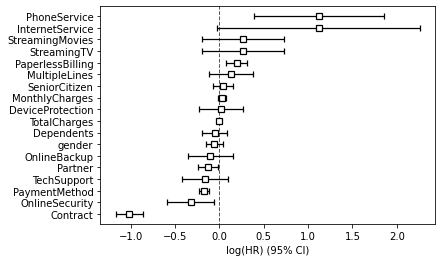

In [21]:
# 5.2 Survival Regression - Lifelines

from lifelines import CoxPHFitter

# Using Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(df, duration_col='tenure', event_col='Churn')
print(cph.print_summary())
cph.plot();